In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# Definição dos caminhos para todos os IDs de fan
path_input_fan_id_00 = os.path.join(os.getcwd(), "..", "..", "MIMII", "fan", "id_00")
path_input_fan_id_02 = os.path.join(os.getcwd(), "..", "..", "MIMII", "fan", "id_02")
path_input_fan_id_04 = os.path.join(os.getcwd(), "..", "..", "MIMII", "fan", "id_04")
path_input_fan_id_06 = os.path.join(os.getcwd(), "..", "..", "MIMII", "fan", "id_06")

In [4]:
import sys
sys.path.append("..")

In [5]:
from mtsa import calculate_aucroc
from mtsa import files_train_test_split
from mtsa import IForest

2024-10-01 17:09:23.812434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 17:09:24.477659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-01 17:09:24.477711: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-01 17:09:24.477717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [6]:
# Lista com todos os caminhos dos IDs de fan
all_fan_paths = [
    path_input_fan_id_00,
    path_input_fan_id_02,
    path_input_fan_id_04,
    path_input_fan_id_06
]

In [7]:
# Listas para armazenar os dados
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

In [8]:
# Coleta e concatenação dos dados de todos os IDs de fan
for path in all_fan_paths:
    X_train_i, X_test_i, y_train_i, y_test_i = files_train_test_split(path)
    X_train_list.append(X_train_i)
    X_test_list.append(X_test_i)
    y_train_list.append(y_train_i)
    y_test_list.append(y_test_i)

In [9]:
# Concatenando todos os dados
X_train = np.concatenate(X_train_list)
X_test = np.concatenate(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

In [10]:
print(f"Conjunto de Treinamento: {X_train.shape}, Labels: {y_train.shape}")
print(f"Conjunto de Teste: {X_test.shape}, Labels: {y_test.shape}")


Conjunto de Treinamento: (2600,), Labels: (2600,)
Conjunto de Teste: (2950,), Labels: (2950,)


In [11]:
model_isolationforest1 = IForest(n_estimators=50, contamination=0.1, max_samples=256, max_features=1.0)
model_isolationforest1.model

Pipeline(steps=[('wav2array', Wav2Array()),
                ('array2mfcc', Array2Mfcc(sampling_rate=None)),
                ('features',
                 FeatureUnion(transformer_list=[('M',
                                                 MagnitudeMeanFeatureMfcc()),
                                                ('S',
                                                 MagnitudeStdFeatureMfcc()),
                                                ('C',
                                                 CorrelationFeatureMfcc())])),
                ('final_model',
                 IsolationForest(contamination=0.1, max_samples=256,
                                 n_estimators=50))])

In [12]:
# Definição da lista de resultados
results = []

# Função para treinar e avaliar o modelo
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    
    training_duration = end_time - start_time
    auc_score = calculate_aucroc(model, X_test, y_test)
    
    print(f"Tempo de Treinamento: {training_duration:.2f} segundos, AUC-ROC: {auc_score:.4f}, modelo: {model_name}")
    
    results.append({
        "model_name": model_name,
        "n_estimators": model.n_estimators,
        "contamination": model.contamination,
        "max_samples": model.max_samples,
        "max_features": model.max_features,
        "training_time": training_duration,
        "auc_roc": auc_score
    })

# Definição do diretório para salvar os resultados
folder_path = '/data/joao/mtsa/experiments'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

train_and_evaluate_model(model_isolationforest1, "IsolationForest_50_estimators", X_train, X_test, y_train, y_test)

model_isolationforest2 = IForest(n_estimators=100, contamination=0.1, max_samples=256, max_features=1.0)
train_and_evaluate_model(model_isolationforest2, "IsolationForest_100_estimators", X_train, X_test, y_train, y_test)

model_isolationforest3 = IForest(n_estimators=200, contamination=0.1, max_samples=256, max_features=1.0)
train_and_evaluate_model(model_isolationforest3, "IsolationForest_200_estimators", X_train, X_test, y_train, y_test)

model_isolationforest4 = IForest(n_estimators=100, contamination=0.1, max_samples=128, max_features=1.0)
train_and_evaluate_model(model_isolationforest4, "IsolationForest_100_estimators_128_samples", X_train, X_test, y_train, y_test)

model_isolationforest5 = IForest(n_estimators=50, contamination=0.1, max_samples=128, max_features=1.0)
train_and_evaluate_model(model_isolationforest5, "IsolationForest_50_estimators_128_samples", X_train, X_test, y_train, y_test)

model_isolationforest6 = IForest(n_estimators=200, contamination=0.1, max_samples=128, max_features=1.0)
train_and_evaluate_model(model_isolationforest6, "IsolationForest_200_estimators_128_samples", X_train, X_test, y_train, y_test)

# Salvando os resultados em um arquivo CSV
df_results = pd.DataFrame(results)
file_path = os.path.join(folder_path, 'isolationforest_Fan_all_ids_with_Array2Mfcc_and_features.csv')
df_results.to_csv(file_path, index=False)
print(f"Resultados salvos em {file_path}")

Tempo de Treinamento: 541.65 segundos, AUC-ROC: 0.5771, modelo: IsolationForest_50_estimators
Tempo de Treinamento: 316.31 segundos, AUC-ROC: 0.5645, modelo: IsolationForest_100_estimators
Tempo de Treinamento: 350.10 segundos, AUC-ROC: 0.5778, modelo: IsolationForest_200_estimators
Tempo de Treinamento: 297.82 segundos, AUC-ROC: 0.5659, modelo: IsolationForest_100_estimators_128_samples
Tempo de Treinamento: 283.66 segundos, AUC-ROC: 0.5678, modelo: IsolationForest_100_estimators
Tempo de Treinamento: 278.95 segundos, AUC-ROC: 0.5751, modelo: IsolationForest_100_estimators
Resultados salvos em /data/joao/mtsa/experiments/isolationforest_Fan_all_ids_with_Array2Mfcc_and_features.csv


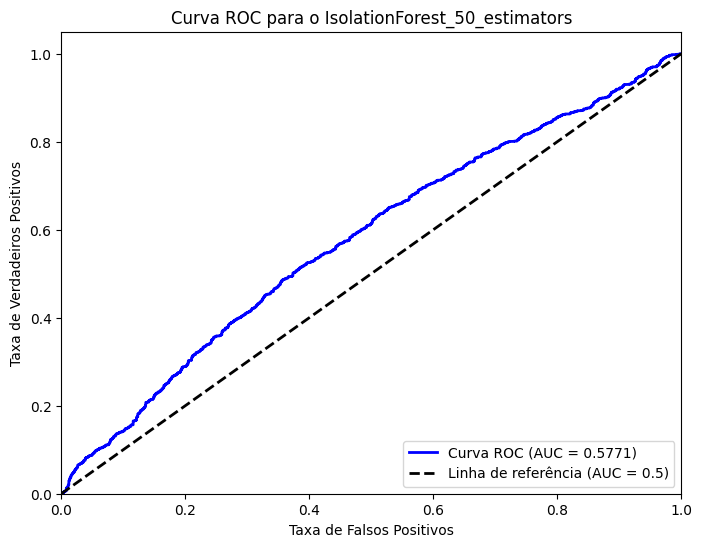

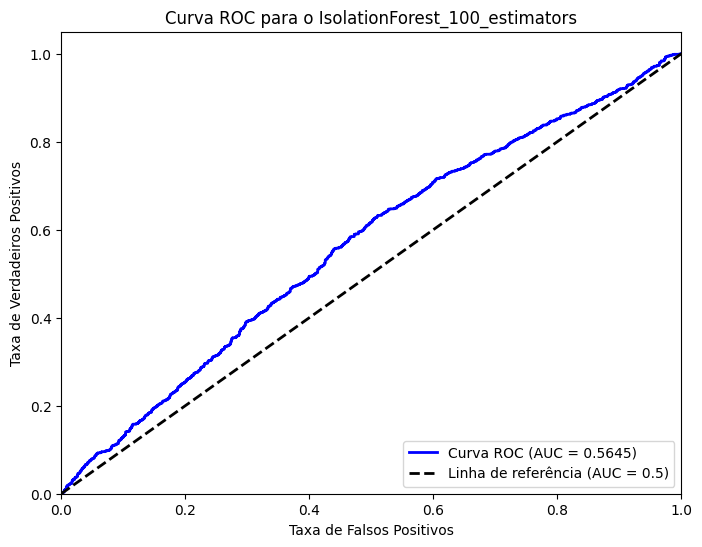

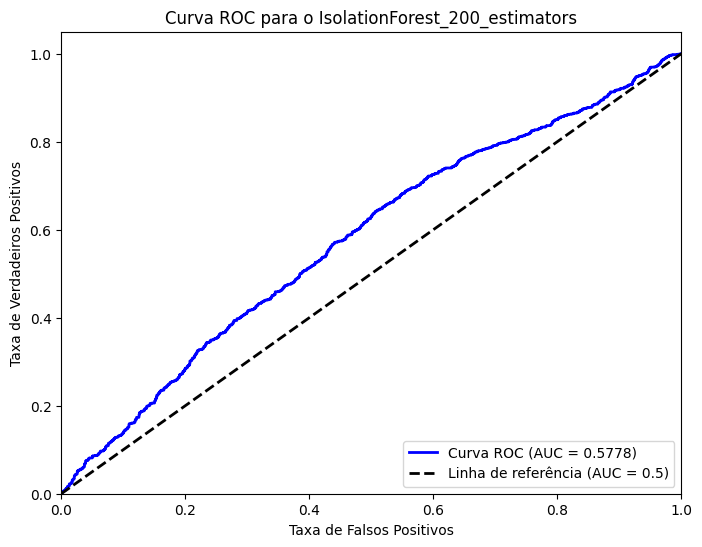

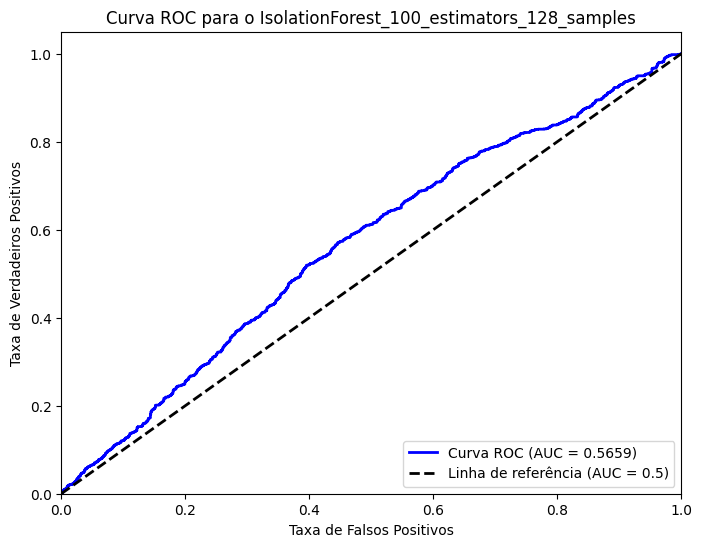

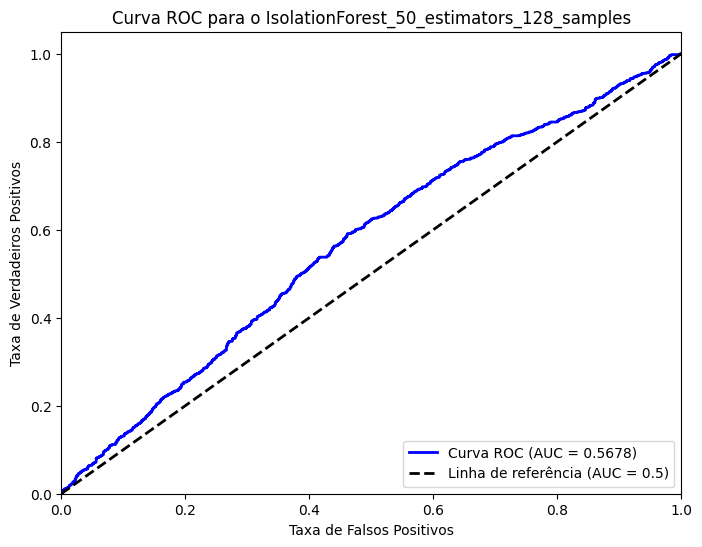

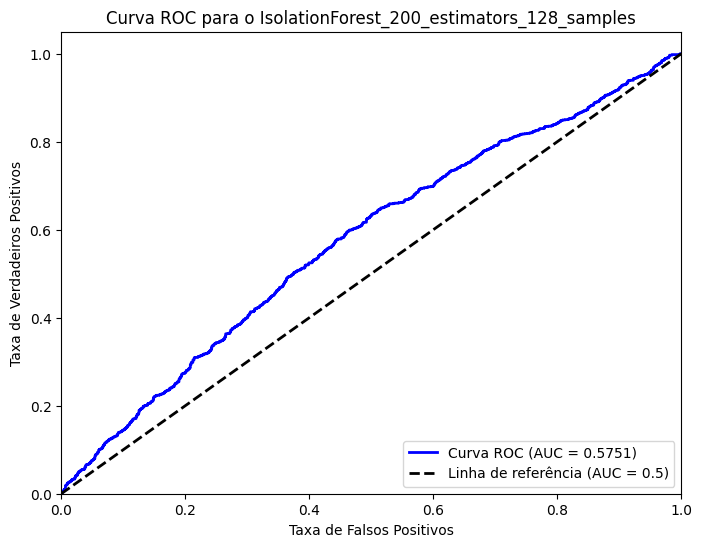

In [13]:
# Função para plotar a curva ROC
def plot_roc_curve(model, X_test, y_test, model_name):
    y_pred_prob = model.score_samples(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Linha de referência (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC para o {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Plotando as curvas ROC para cada modelo
plot_roc_curve(model_isolationforest1, X_test, y_test, "IsolationForest_50_estimators")
plot_roc_curve(model_isolationforest2, X_test, y_test, "IsolationForest_100_estimators")
plot_roc_curve(model_isolationforest3, X_test, y_test, "IsolationForest_200_estimators")
plot_roc_curve(model_isolationforest4, X_test, y_test, "IsolationForest_100_estimators_128_samples")
plot_roc_curve(model_isolationforest5, X_test, y_test, "IsolationForest_50_estimators_128_samples")
plot_roc_curve(model_isolationforest6, X_test, y_test, "IsolationForest_200_estimators_128_samples")

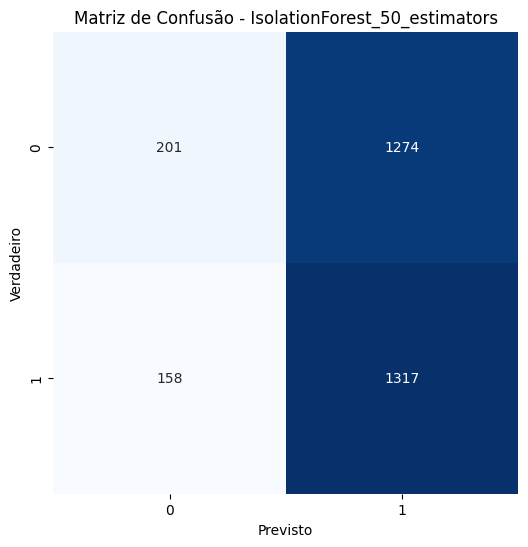

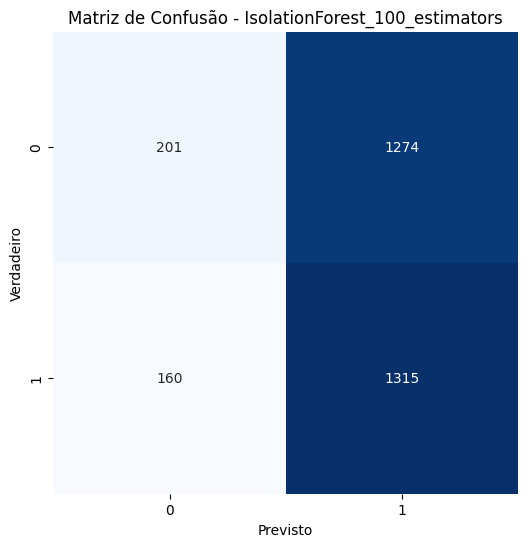

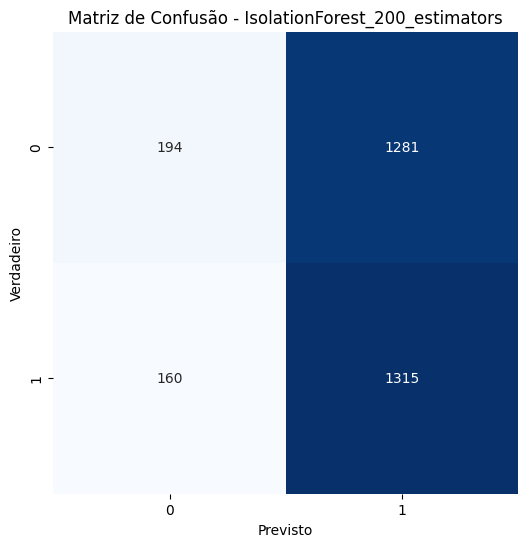

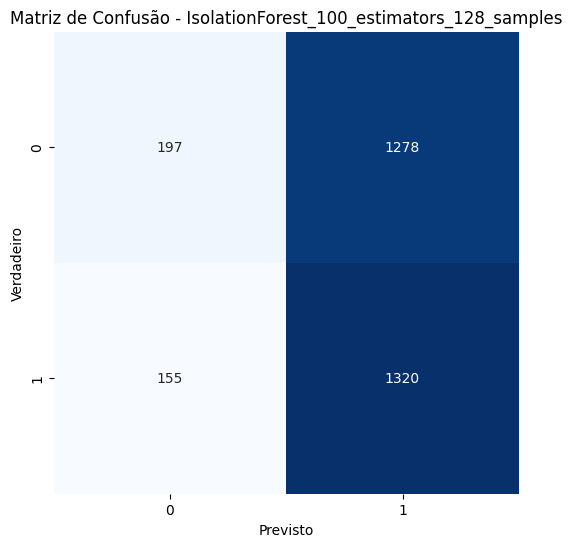

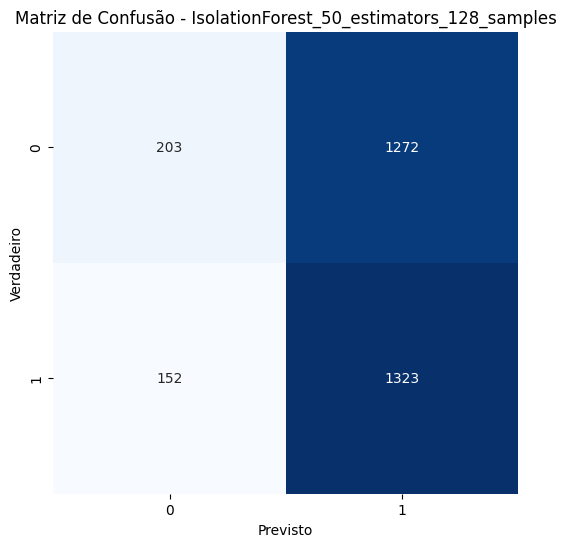

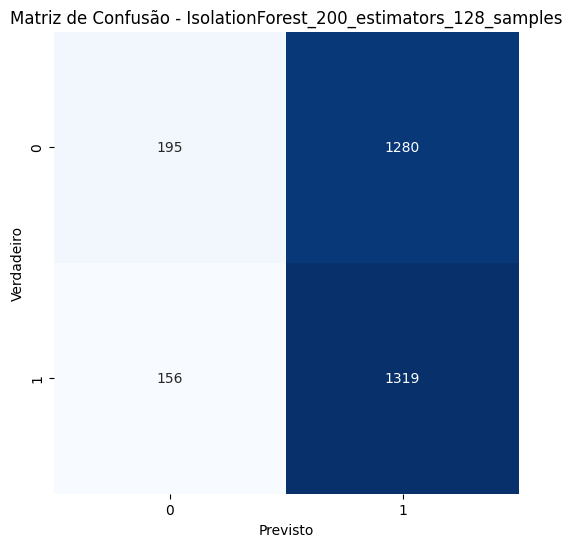

In [14]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

# Plotando as matrizes de confusão para cada modelo
plot_confusion_matrix(model_isolationforest1, X_test, y_test, "IsolationForest_50_estimators")
plot_confusion_matrix(model_isolationforest2, X_test, y_test, "IsolationForest_100_estimators")
plot_confusion_matrix(model_isolationforest3, X_test, y_test, "IsolationForest_200_estimators")
plot_confusion_matrix(model_isolationforest4, X_test, y_test, "IsolationForest_100_estimators_128_samples")
plot_confusion_matrix(model_isolationforest5, X_test, y_test, "IsolationForest_50_estimators_128_samples")
plot_confusion_matrix(model_isolationforest6, X_test, y_test, "IsolationForest_200_estimators_128_samples")